# 3 - Mapas

Vamos também gerar alguns mapas como parte de nossa análise de dados. Afinal, temos 96 gráficos, e precisamos extrair as principais informações dos dados. Os mapas que faremos serão:

- Atendimento (matrícula) absoluto por tempo.
- Atendimento (matrícula) relativo (relação à população) por tempo.
- Fila (demanda) absoluto por tempo.
- Fila (demanda) relativo por tempo.
- Variação entre junho de 2016 e dezembro de 2017 do atendimento absoluto.
- Variação entre junho de 2016 e dezembro de 2017 do atendimento relativo.

## Mapas do atendimento absoluto por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). O gradiente utilizado vai de branco a verde-escuro.

<Figure size 3600x4800 with 0 Axes>

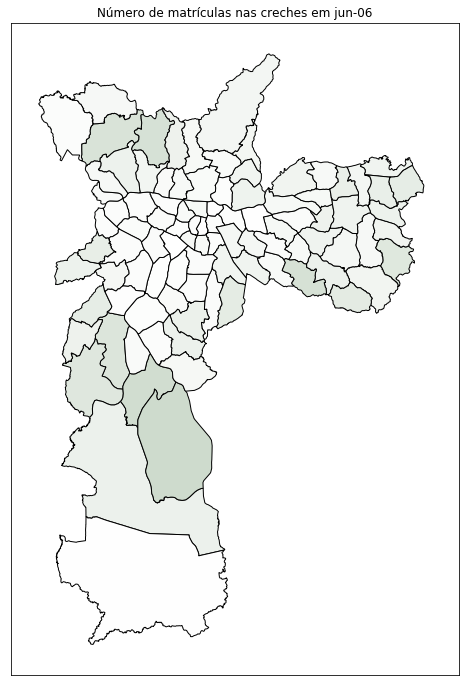

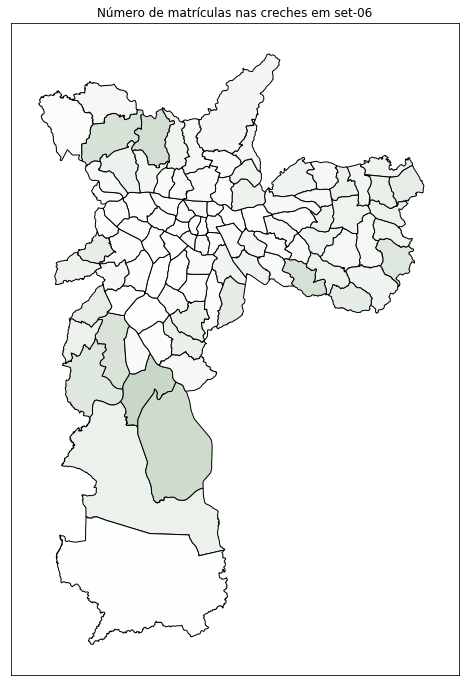

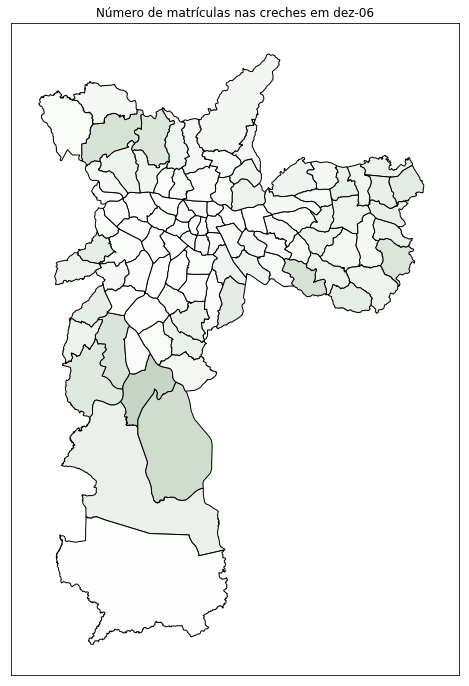

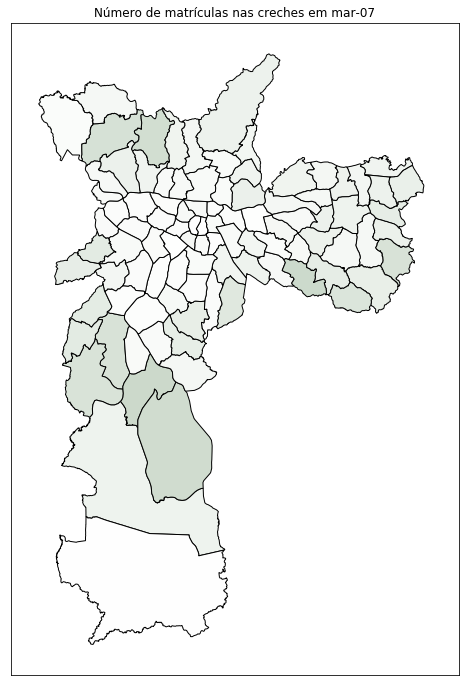

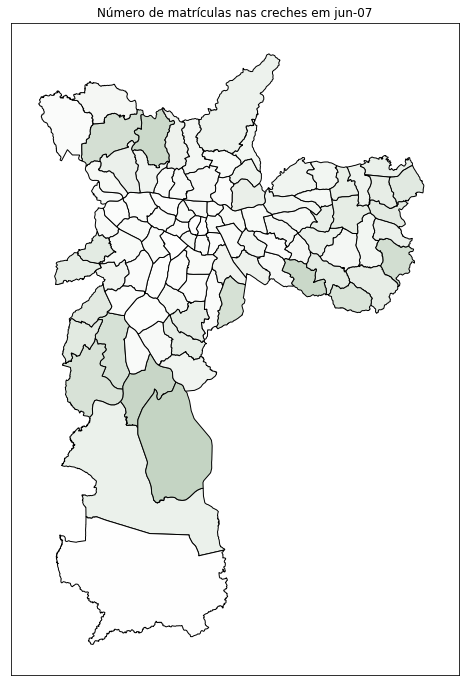

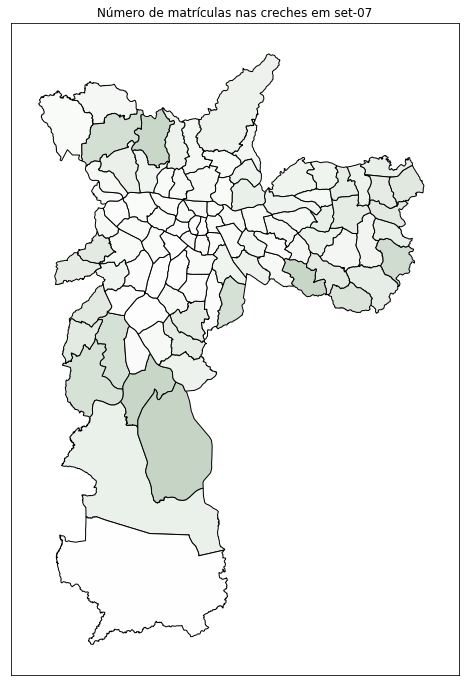

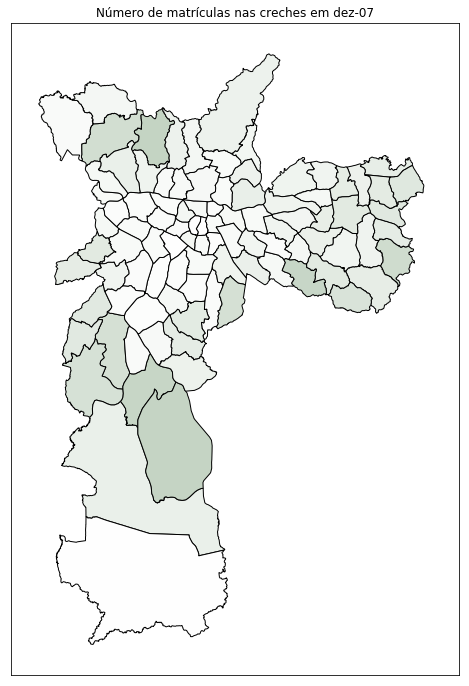

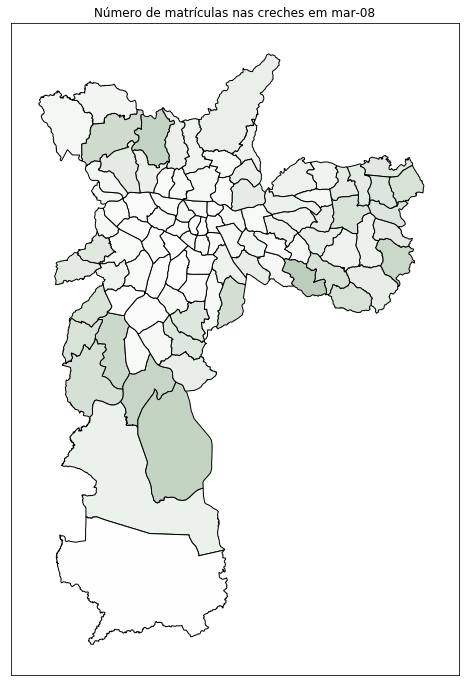

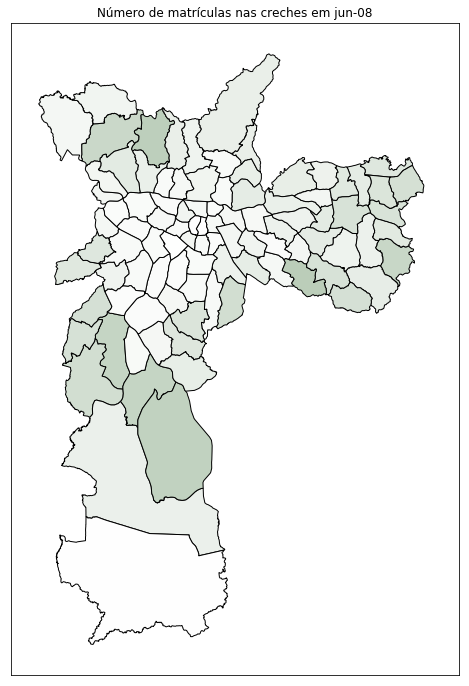

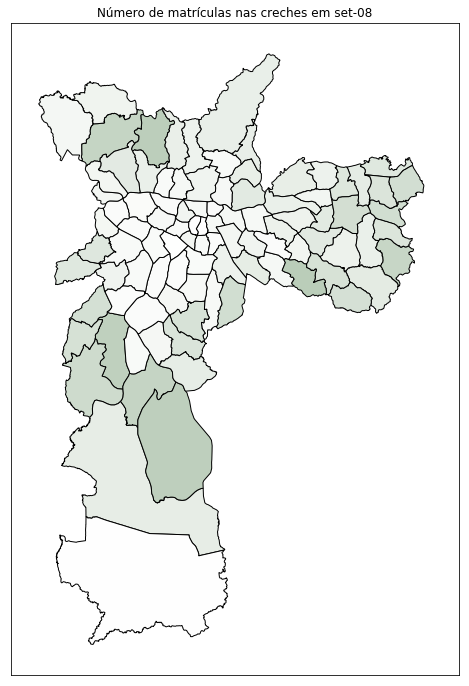

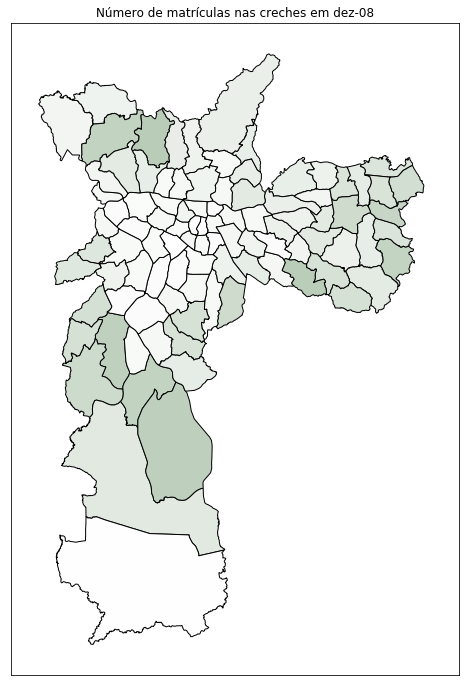

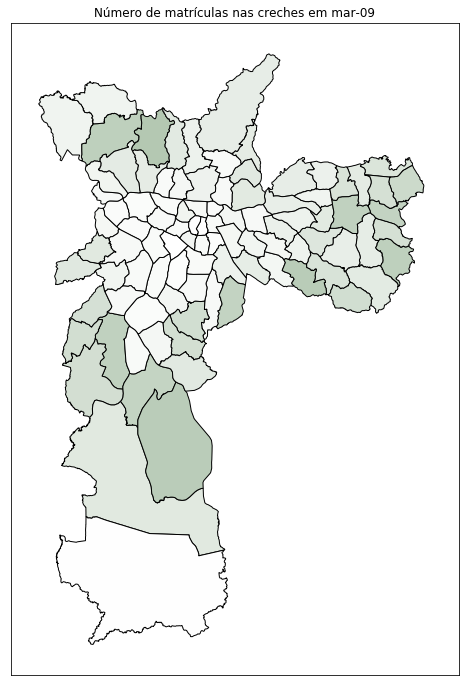

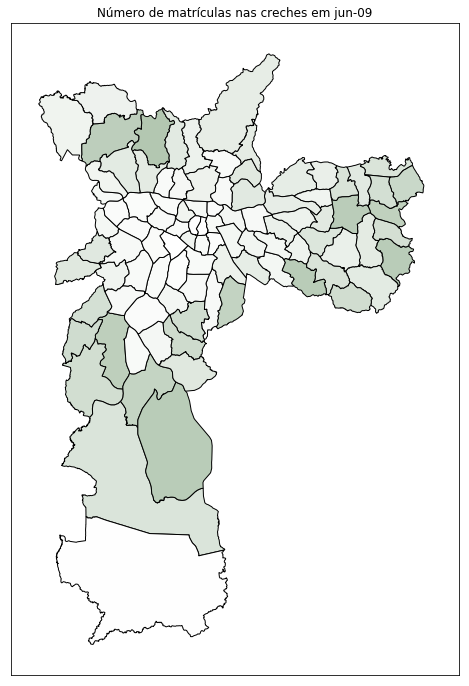

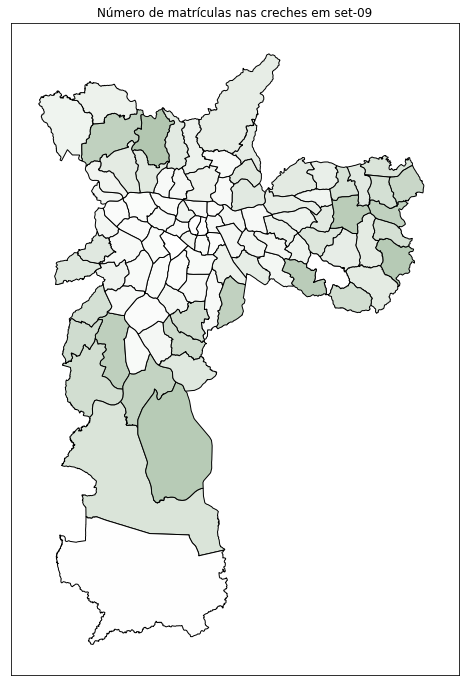

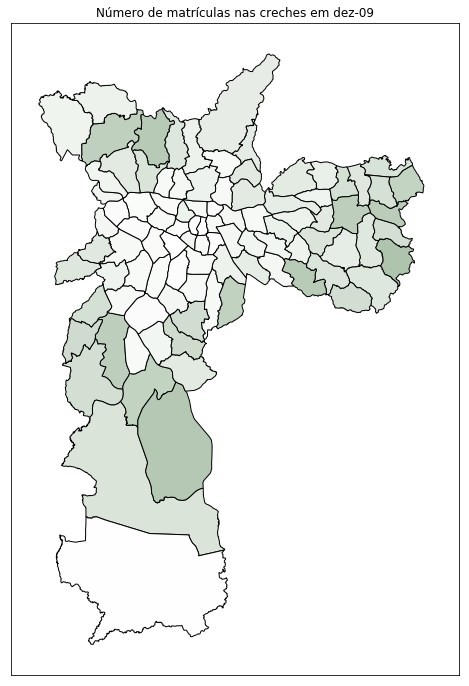

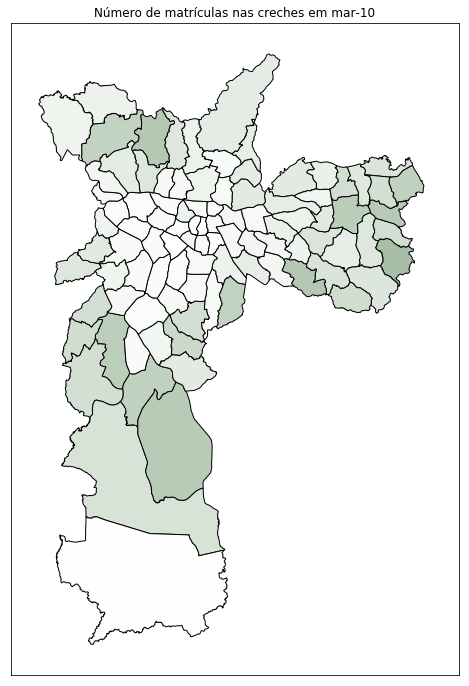

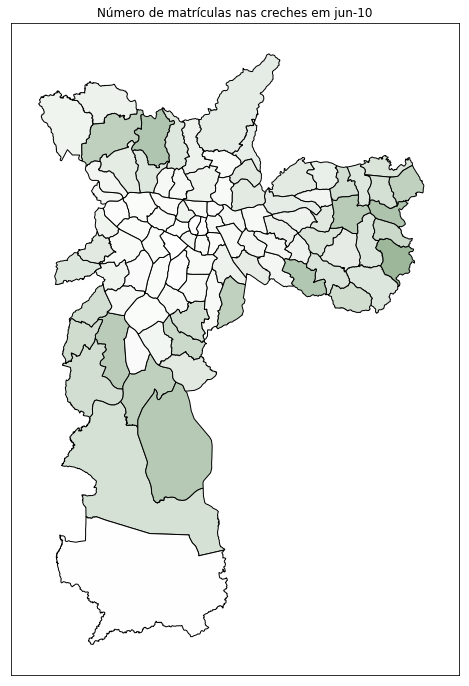

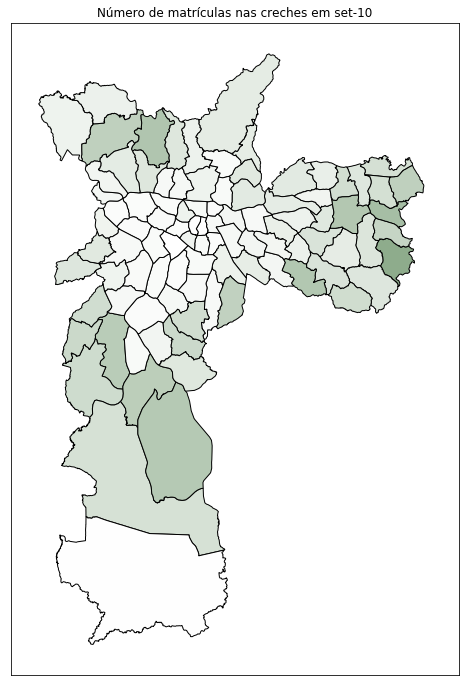

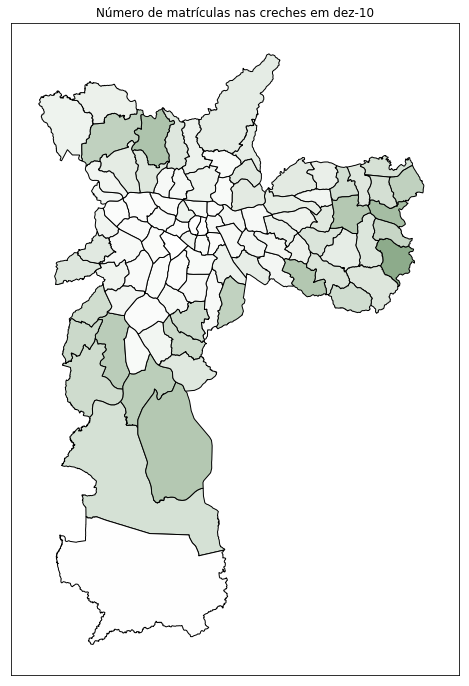

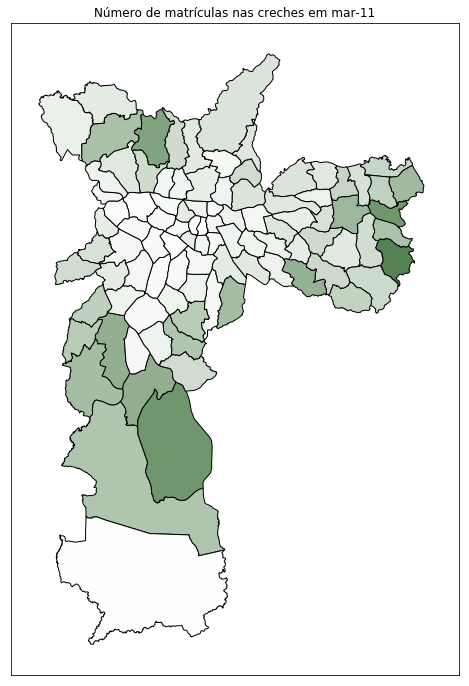

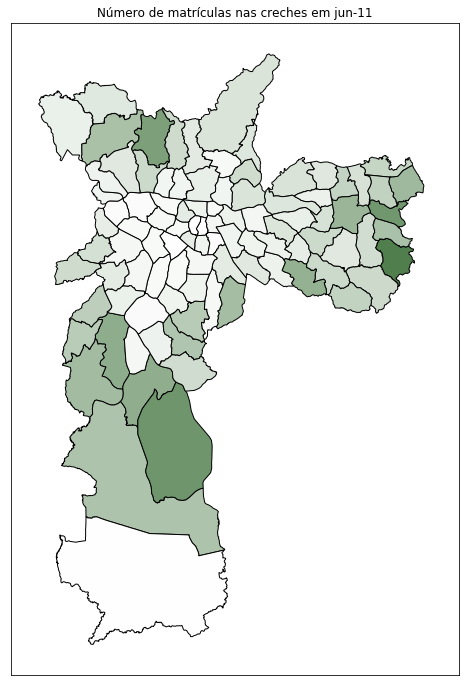

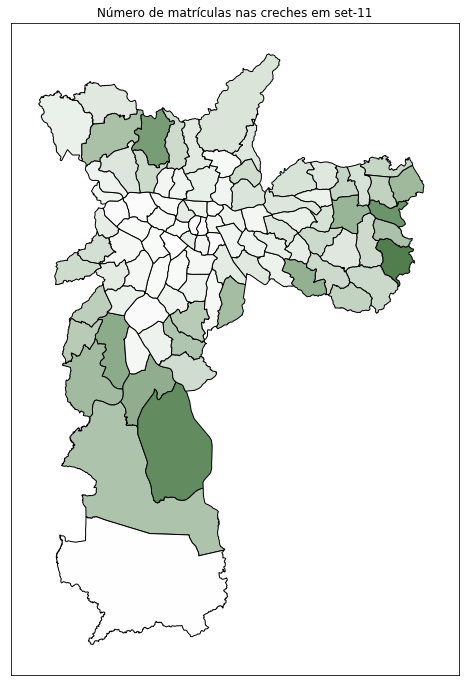

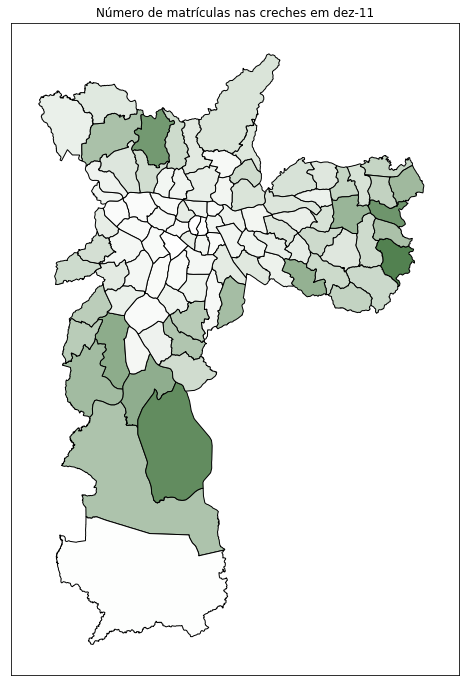

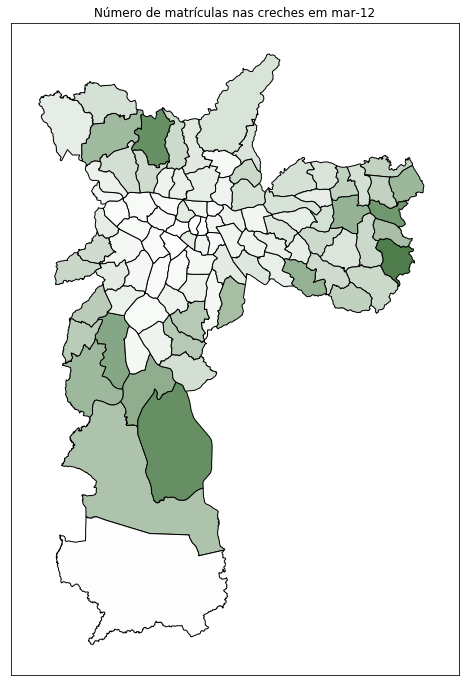

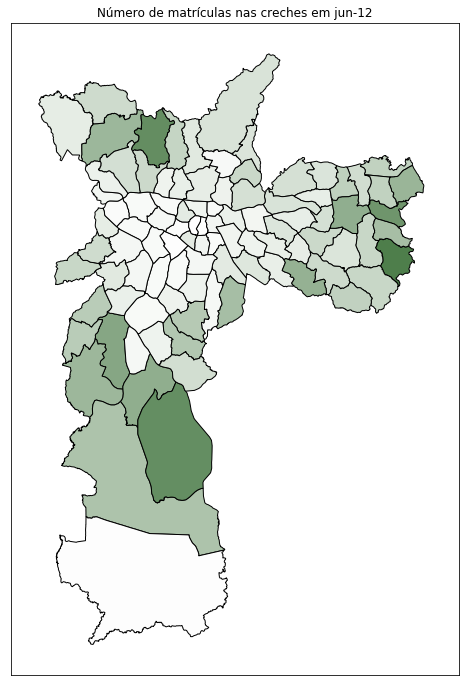

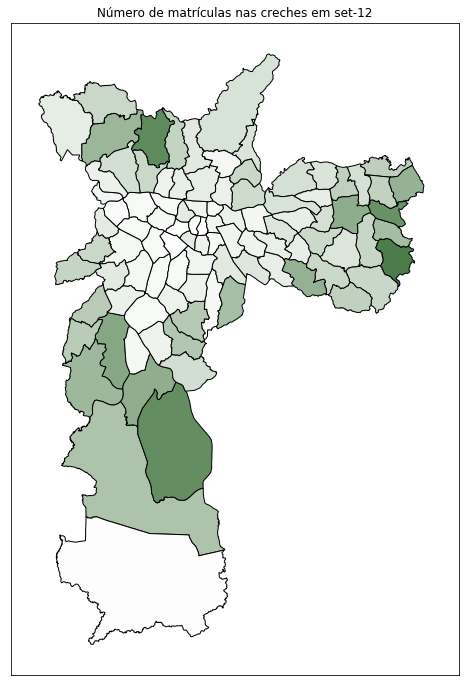

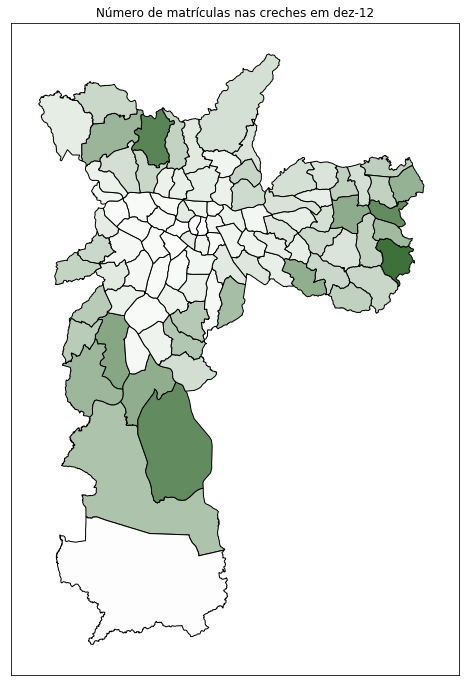

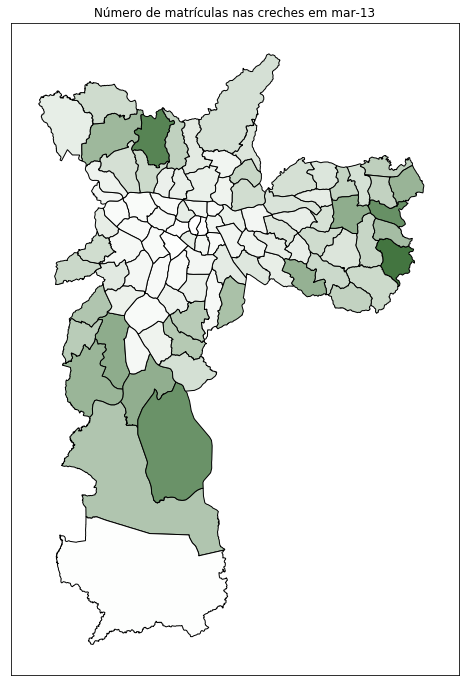

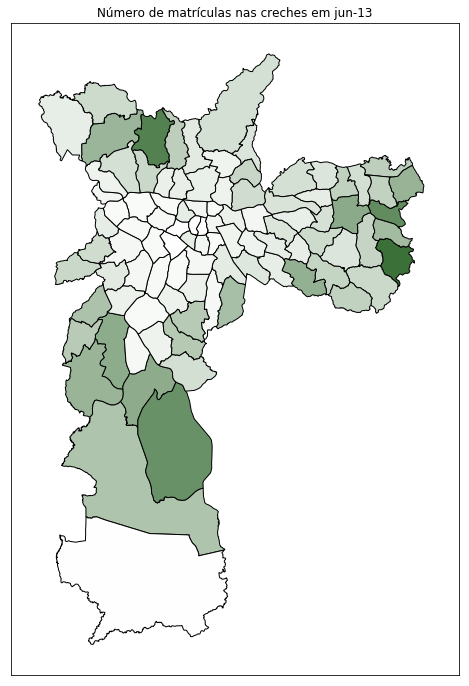

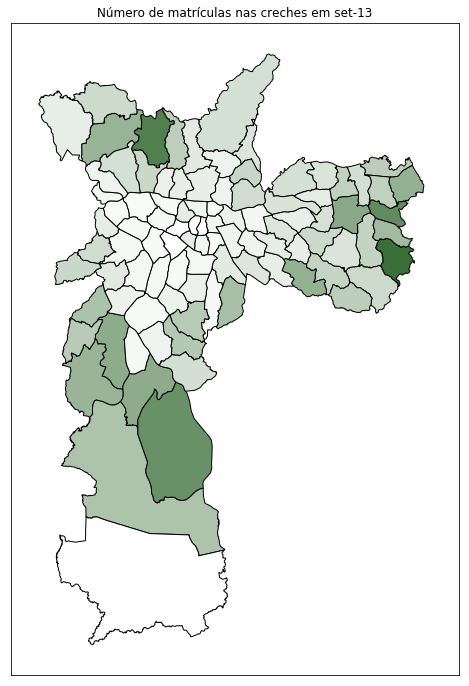

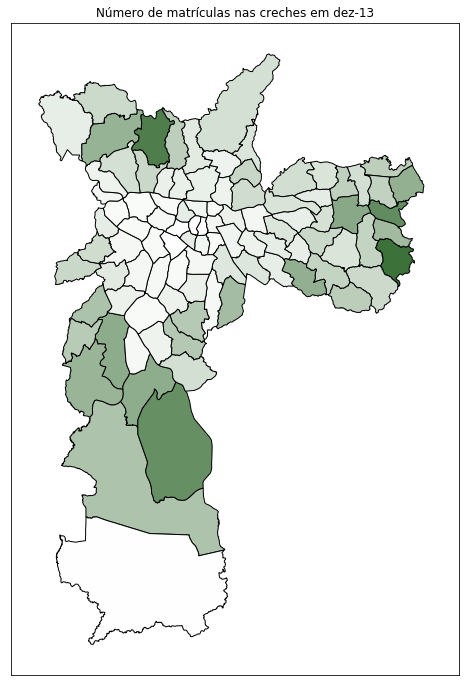

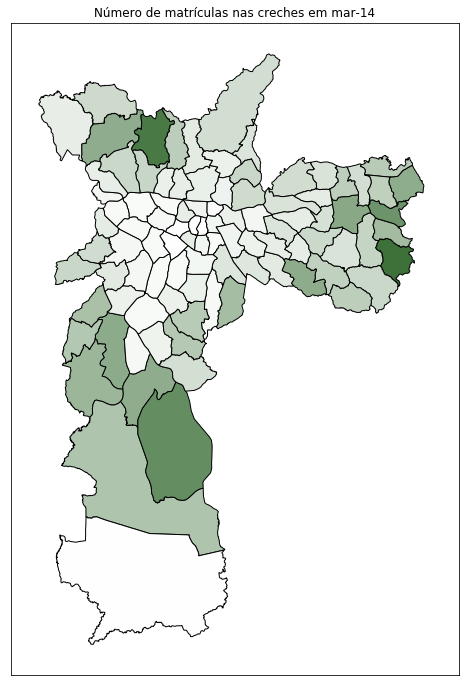

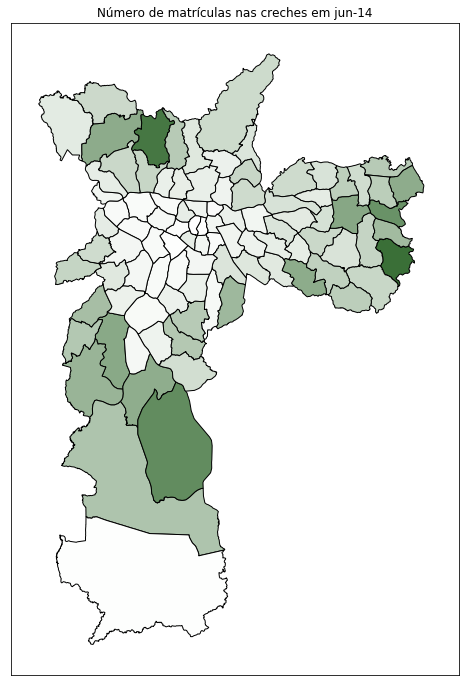

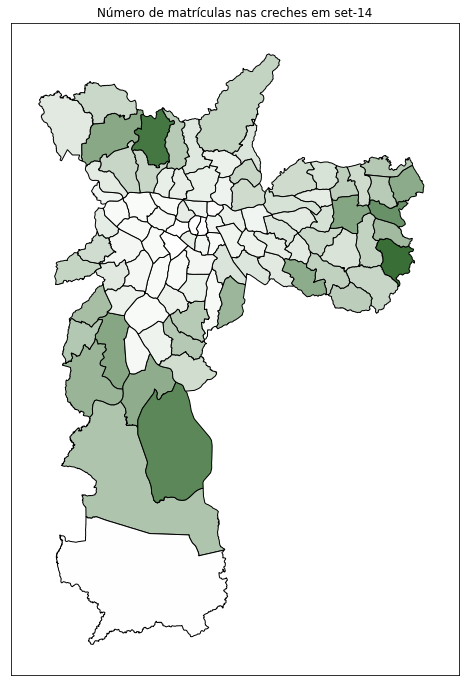

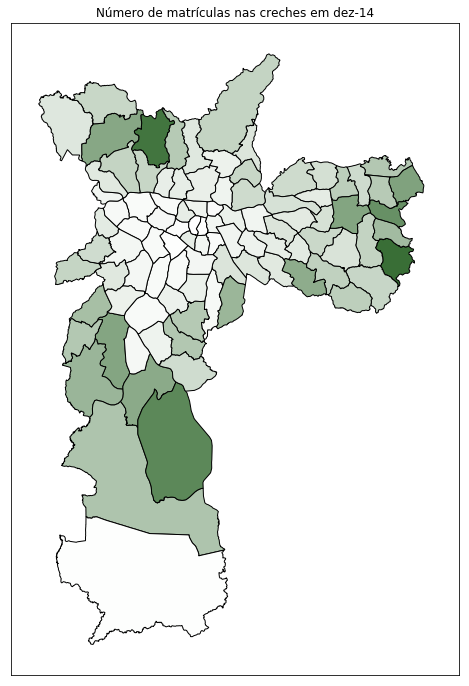

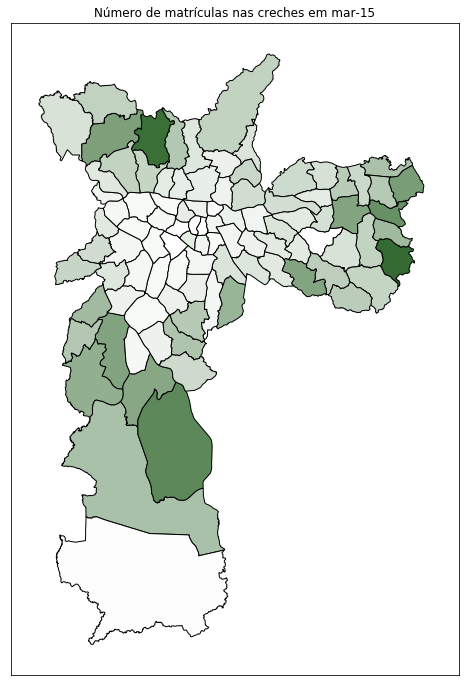

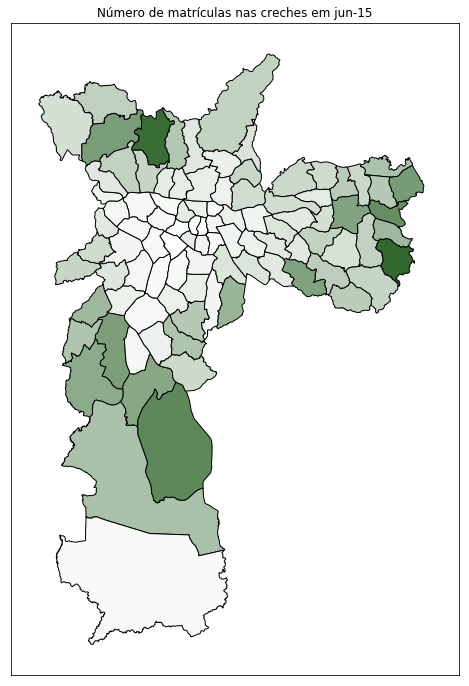

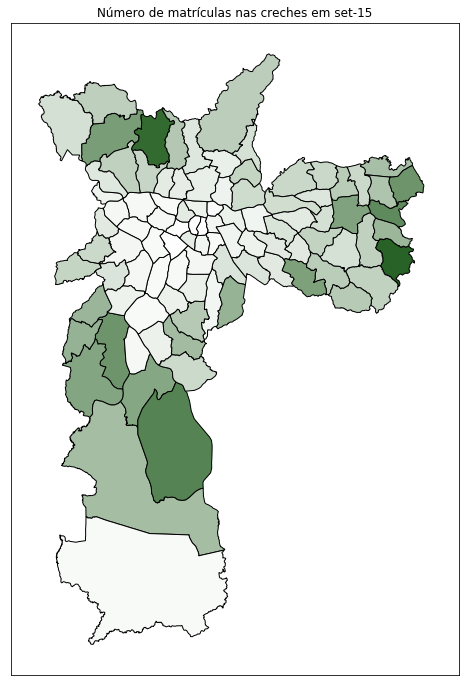

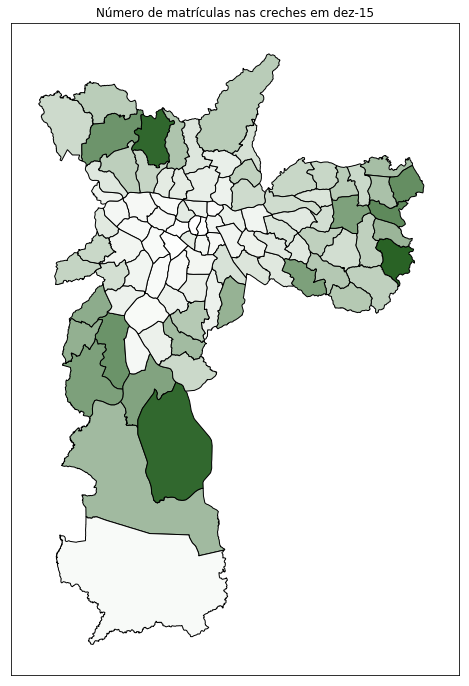

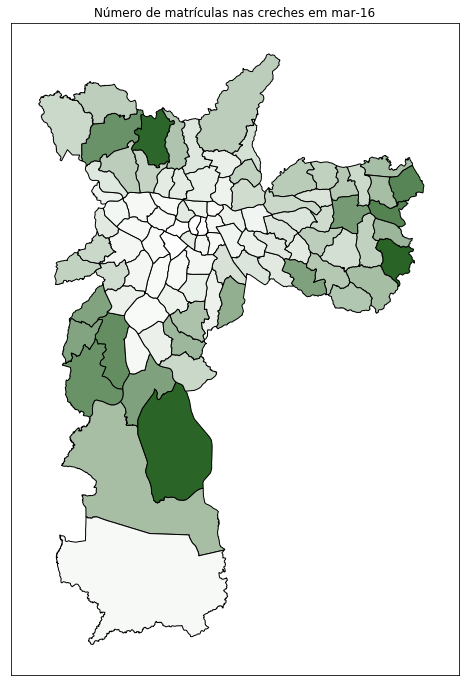

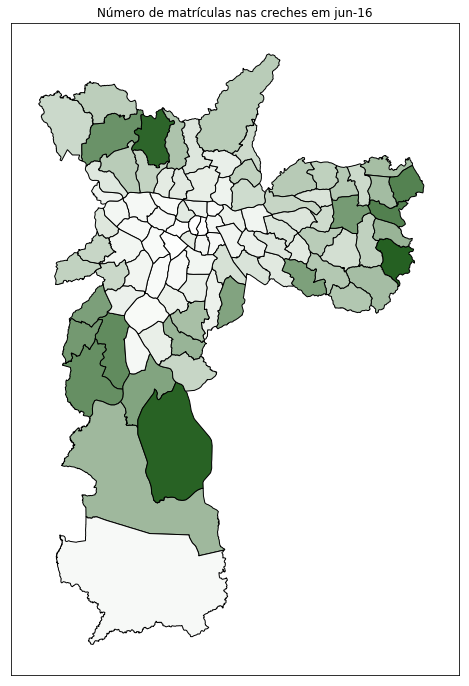

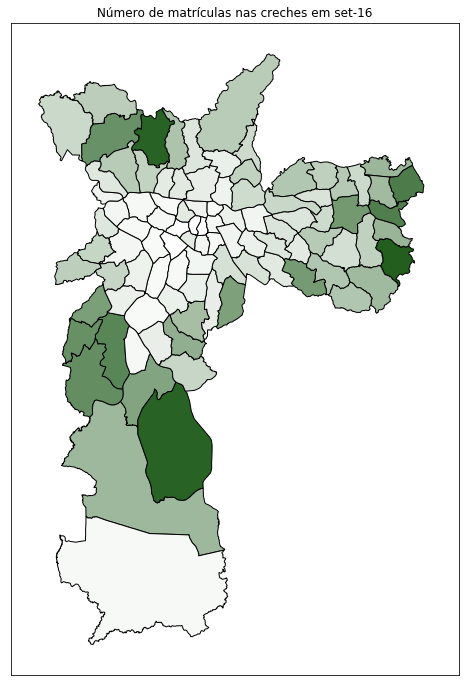

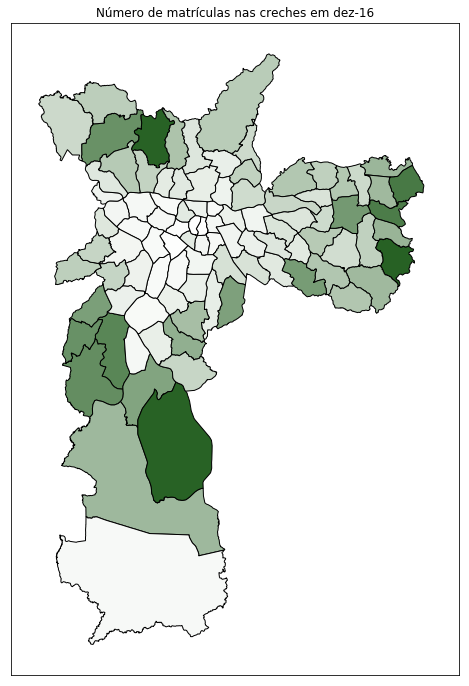

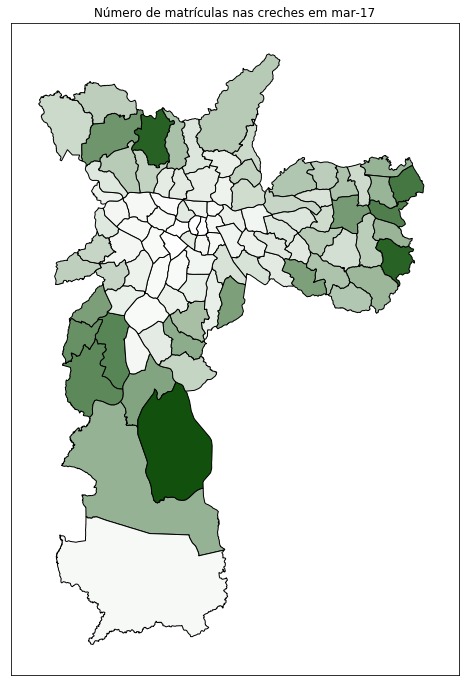

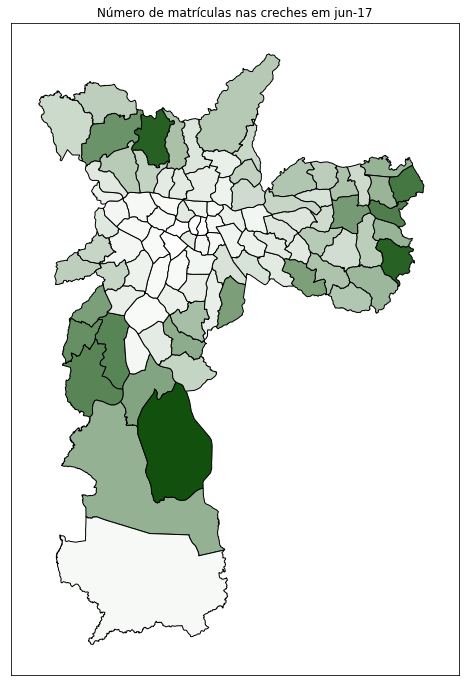

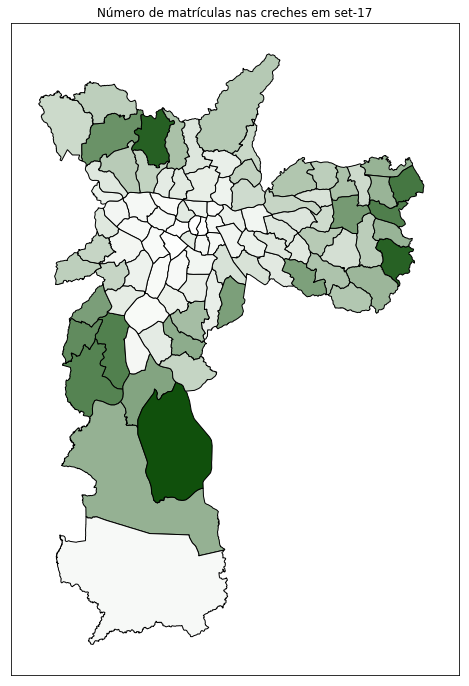

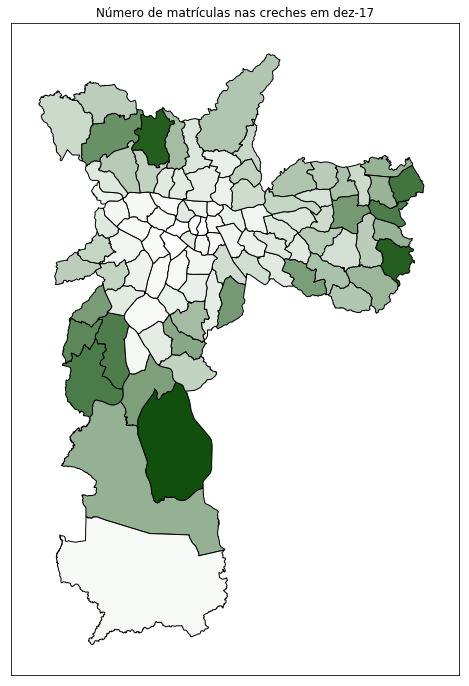

In [42]:
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from matplotlib.pyplot import figure
from pylab import rcParams

rcParams['figure.figsize'] = 9, 12 
figure(num=None, dpi=400, facecolor='w', edgecolor='k')

dados_educ_pop = pd.read_csv('dados/dados_educ_pop.csv', sep = ',')

# Gerando os mapas de calor.
for periodo in dados_educ_pop.MES_ANO_REF.unique():
    dados = dados_educ_pop[dados_educ_pop['MES_ANO_REF'] == periodo]
    atendimento_absoluto = dados.sort_values(by='MAT_CRECHE', ascending=False)
    atendimento_absoluto = atendimento_absoluto[['DISTRITO', 'MAT_CRECHE']]

    sf = shp.Reader("dados/LAYER_DISTRITO/DEINFO_DISTRITO.shp")

    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    
    for shapeRec in sf.iterShapeRecords():
        shape = shapeRec.shape
        rec = shapeRec.record
        
        nome = rec[3].split(" ")
        if 'JD' in nome:
            nome[0] = "JARDIM"
        if 'CID' in nome:
            nome[0] = "CIDADE"
        rec[3] = " ".join(nome)

        dado = atendimento_absoluto[atendimento_absoluto['DISTRITO'] == rec[3]]
        mat = int(dado['MAT_CRECHE'].values)

        R = 1 - 246.0/255*(mat/12846.0)
        G = 1 - 180.0/255*(mat/12846.0)
        B = 1 - 250.0/255*(mat/12846.0)

        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=[R,G,B], edgecolor=[0,0,0], alpha=1.0, zorder=2)
        ax.add_patch(patch)
    
    plt.title('Número de matrículas nas creches em ' + periodo)
    plt.ylim(7340000,7420000)
    plt.xlim(310000,365000)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.show()

## Lista do atendimento relativo por tempo

Para essa lista, será gerado um arquivo .csv para cada período de referência (trimestre) com os distritos ordenados pelo quociente matrículas por total populacional.

In [2]:
dados_educ_pop['ATEND_REL'] = dados_educ_pop['MAT_CRECHE'] / dados_educ_pop['TOTAL']

for periodo in dados_educ_pop.MES_ANO_REF.unique():
    dados = dados_educ_pop[dados_educ_pop['MES_ANO_REF'] == periodo]
    atendimento_relativo = dados.sort_values(by='ATEND_REL', ascending=False)
    atendimento_relativo = atendimento_relativo[['DISTRITO', 'ATEND_REL']] 
    atendimento_relativo.to_csv('resultados/atendimento_relativo/atendimento_relativo_' + periodo + '.csv', encoding='utf-8', index=False)

## Lista da fila absoluta por tempo

Para essa lista, será gerado um arquivo .csv para cada período de referência (trimestre) com os distritos ordenados pelo número de crianças na fila.

In [3]:
# Gerando os arquivos
for periodo in dados_educ_pop.MES_ANO_REF.unique():
    dados = dados_educ_pop[dados_educ_pop['MES_ANO_REF'] == periodo]
    fila_absoluta = dados.sort_values(by='DEM_CRECHE', ascending=False)
    fila_absoluta = fila_absoluta[['DISTRITO', 'DEM_CRECHE']] 
    fila_absoluta.to_csv('resultados/fila_absoluta/fila_absoluta_' + periodo + '.csv', encoding='utf-8', index=False)

## Lista da fila relativa por tempo

Para essa lista, será gerado um arquivo .csv para cada período de referência (trimestre) com os distritos ordenados pelo quociente demanda por total populacional.

In [4]:
dados_educ_pop['FILA_REL'] = dados_educ_pop['DEM_CRECHE'] / dados_educ_pop['TOTAL']

for periodo in dados_educ_pop.MES_ANO_REF.unique():
    dados = dados_educ_pop[dados_educ_pop['MES_ANO_REF'] == periodo]
    fila_relativa = dados.sort_values(by='FILA_REL', ascending=False)
    fila_relativa = fila_relativa[['DISTRITO', 'FILA_REL']] 
    fila_relativa.to_csv('resultados/fila_relativa/fila_relativa_' + periodo + '.csv', encoding='utf-8', index=False)

## Lista da evolução absoluta do número de matrículas

Essa lista trará a variação, do número de matrículas, de junho de 2006 a dezembro de 2017. A última coluna trará a variação percentual desses valores.

In [5]:
dados_matricula = dados_educ_pop[['DISTRITO', 'MAT_CRECHE', 'MES_ANO_REF']]
dados_jun_2006 = dados_matricula[dados_matricula['MES_ANO_REF'] == 'jun-06']
dados_jun_2006.columns = ['DISTRITO', 'MAT_JUN_06', 'MES_ANO_REF']
dados_dez_2017 = dados_matricula[dados_matricula['MES_ANO_REF'] == 'dez-17']
dados_dez_2017.columns = ['DISTRITO', 'MAT_DEZ_17', 'MES_ANO_REF']

dados_matricula = dados_jun_2006.merge(dados_dez_2017, on = ['DISTRITO'])
dados_matricula = dados_matricula[['DISTRITO', 'MAT_JUN_06', 'MAT_DEZ_17']]

dados_matricula['EV_ABS_NUM'] = dados_matricula['MAT_DEZ_17'] - dados_matricula['MAT_JUN_06']
dados_matricula['EV_ABS_PC'] = dados_matricula['MAT_DEZ_17'] / dados_matricula['MAT_JUN_06']
# dados_matricula.sort_values(by='EV_ABS_NUM', ascending=False)
# dados_matricula.sort_values(by='EV_ABS_PC', ascending=False)

DISTRITO  MAT_JUN_06  MAT_DEZ_17  EV_ABS_NUM  EV_ABS_PC
29              GRAJAU      2555.0     12486.0      9931.0   4.886888
24   CIDADE TIRADENTES      1676.0     11423.0      9747.0   6.815632
10         BRASILANDIA      2121.0     11488.0      9367.0   5.416313
34      ITAIM PAULISTA      1284.0      9897.0      8613.0   7.707944
46             LAJEADO       947.0      9361.0      8414.0   9.884900
41       JARDIM ANGELA      1683.0      9408.0      7725.0   5.590018
18       CAPAO REDONDO       902.0      8456.0      7554.0   9.374723
44     JARDIM SAO LUIS      1847.0      9257.0      7410.0   5.011911
35            ITAQUERA       843.0      7211.0      6368.0   8.553974
40             JARAGUA      2008.0      7870.0      5862.0   3.919323
68              SACOMA      1380.0      7199.0      5819.0   5.216667
16         CAMPO LIMPO      1286.0      6963.0      5677.0   5.414463
21       CIDADE ADEMAR       981.0      6211.0      5230.0   6.331295
77           SAPOPEMBA      2133.0      6939.0      4806.0   3.253165
30          GUAIANASES       750.0      5438.0      4688.0   7.250667
42       JARDIM HELENA       792.0      5452.0      4660.0   6.883838
55         PARELHEIROS       980.0      5573.0      4593.0   5.686735
31            IGUATEMI       704.0      5240.0      4536.0   7.443182
22        CIDADE DUTRA      2421.0      6763.0      4342.0   2.793474
85         VILA CURUCA      1136.0      5349.0      4213.0   4.708627
12        CACHOEIRINHA       909.0      4798.0      3889.0   5.278328
36           JABAQUARA      1004.0      4746.0      3742.0   4.727092
82            TREMEMBE       616.0      4078.0      3462.0   6.620130
17            CANGAIBA       750.0      4145.0      3395.0   5.526667
74          SAO MATEUS       989.0      4382.0      3393.0   4.430738
88          VILA JACUI      1109.0      4368.0      3259.0   3.938683
27  ERMELINO MATARAZZO       422.0      3631.0      3209.0   8.604265
45      JOSE BONIFACIO       473.0      3569.0      3096.0   7.545455
61               PERUS       484.0      3484.0      3000.0   7.198347
23        CIDADE LIDER       822.0      3795.0      2973.0   4.616788
..                 ...         ...         ...         ...        ...
83            TUCURUVI       291.0      1154.0       863.0   3.965636
87      VILA GUILHERME       176.0       933.0       757.0   5.301136
14          CAMPO BELO       336.0      1084.0       748.0   3.226190
54             MORUMBI       209.0       944.0       735.0   4.516746
38             JAGUARA       324.0      1019.0       695.0   3.145062
81             TATUAPE        73.0       675.0       602.0   9.246575
0            AGUA RASA       573.0      1045.0       472.0   1.823735
8           BOM RETIRO       452.0       910.0       458.0   2.013274
11             BUTANTA       231.0       654.0       423.0   2.831169
89     VILA LEOPOLDINA       214.0       635.0       421.0   2.967290
91        VILA MARIANA       259.0       676.0       417.0   2.610039
56                PARI        54.0       430.0       376.0   7.962963
51            MARSILAC        63.0       421.0       358.0   6.682540
13             CAMBUCI       131.0       475.0       344.0   3.625954
47                LAPA       185.0       515.0       330.0   2.783784
9                 BRAS       199.0       511.0       312.0   2.567839
33          ITAIM BIBI        95.0       392.0       297.0   4.126316
71         SANTO AMARO       136.0       391.0       255.0   2.875000
52               MOEMA       146.0       401.0       255.0   2.746575
48           LIBERDADE       391.0       646.0       255.0   1.652174
60            PERDIZES       286.0       532.0       246.0   1.860140
53               MOOCA       551.0       778.0       227.0   1.411978
80             SOCORRO       327.0       546.0       219.0   1.669725
1    ALTO DE PINHEIROS       236.0       404.0       168.0   1.711864
62           PINHEIROS       251.0       381.0       130.0   1.517928
5          BARRA FUNDA  

## Lista da evolução absoluta da demanda

Essa lista trará a variação, em número de crianças, de junho de 2006 a dezembro de 2017. A última coluna trará a variação percentual desses valores.

In [6]:
dados_demanda = dados_educ_pop[['DISTRITO', 'DEM_CRECHE', 'MES_ANO_REF']]
dados_jun_2006 = dados_demanda[dados_demanda['MES_ANO_REF'] == 'jun-06']
dados_jun_2006.columns = ['DISTRITO', 'DEM_JUN_06', 'MES_ANO_REF']
dados_dez_2017 = dados_demanda[dados_demanda['MES_ANO_REF'] == 'dez-17']
dados_dez_2017.columns = ['DISTRITO', 'DEM_DEZ_17', 'MES_ANO_REF']

dados_demanda = dados_jun_2006.merge(dados_dez_2017, on = ['DISTRITO'])
dados_demanda = dados_demanda[['DISTRITO', 'DEM_JUN_06', 'DEM_DEZ_17']]

dados_demanda['EV_ABS_NUM'] = dados_demanda['DEM_DEZ_17'] - dados_demanda['DEM_JUN_06']
dados_demanda['EV_ABS_PC'] = dados_demanda['DEM_DEZ_17'] / dados_demanda['DEM_JUN_06']
# dados_demanda.sort_values(by='EV_ABS_NUM', ascending=True)
# dados_demanda.sort_values(by='EV_ABS_PC', ascending=True)

DISTRITO  DEM_JUN_06  DEM_DEZ_17  EV_ABS_NUM   EV_ABS_PC
68              SACOMA      2203.0       347.0     -1856.0    0.157512
29              GRAJAU      3914.0      2269.0     -1645.0    0.579714
36           JABAQUARA      2279.0       708.0     -1571.0    0.310663
46             LAJEADO      1611.0       101.0     -1510.0    0.062694
10         BRASILANDIA      2392.0       914.0     -1478.0    0.382107
34      ITAIM PAULISTA      1963.0       512.0     -1451.0    0.260825
24   CIDADE TIRADENTES      1559.0       178.0     -1381.0    0.114176
44     JARDIM SAO LUIS      3674.0      2370.0     -1304.0    0.645073
16         CAMPO LIMPO      3051.0      1750.0     -1301.0    0.573582
21       CIDADE ADEMAR      3214.0      2009.0     -1205.0    0.625078
22        CIDADE DUTRA      1934.0       865.0     -1069.0    0.447260
76          SAO RAFAEL      2420.0      1412.0     -1008.0    0.583471
17            CANGAIBA      1225.0       230.0      -995.0    0.187755
74          SAO MATEUS      1562.0       574.0      -988.0    0.367478
40             JARAGUA      1609.0       626.0      -983.0    0.389062
85         VILA CURUCA      1134.0       204.0      -930.0    0.179894
67         RIO PEQUENO      1140.0       221.0      -919.0    0.193860
77           SAPOPEMBA      2781.0      1910.0      -871.0    0.686803
35            ITAQUERA      1120.0       260.0      -860.0    0.232143
41       JARDIM ANGELA      3539.0      2683.0      -856.0    0.758124
23        CIDADE LIDER      1356.0       505.0      -851.0    0.372419
12        CACHOEIRINHA      1167.0       345.0      -822.0    0.295630
61               PERUS       911.0       176.0      -735.0    0.193194
27  ERMELINO MATARAZZO       901.0       166.0      -735.0    0.184240
45      JOSE BONIFACIO       789.0        83.0      -706.0    0.105196
63            PIRITUBA       955.0       370.0      -585.0    0.387435
64          PONTE RASA       605.0        32.0      -573.0    0.052893
94       VILA PRUDENTE       686.0       117.0      -569.0    0.170554
59               PENHA       623.0        55.0      -568.0    0.088283
93       VILA MEDEIROS       802.0       247.0      -555.0    0.307980
..                 ...         ...         ...         ...         ...
15        CAMPO GRANDE       431.0       321.0      -110.0    0.744780
62           PINHEIROS       230.0       120.0      -110.0    0.521739
83            TUCURUVI       212.0       106.0      -106.0    0.500000
86        VILA FORMOSA       305.0       211.0       -94.0    0.691803
7                BELEM       285.0       198.0       -87.0    0.694737
60            PERDIZES       200.0       120.0       -80.0    0.600000
37              JACANA       830.0       755.0       -75.0    0.909639
80             SOCORRO       160.0        88.0       -72.0    0.550000
25          CONSOLACAO       122.0        75.0       -47.0    0.614754
78               SAUDE       238.0       200.0       -38.0    0.840336
89     VILA LEOPOLDINA       145.0       107.0       -38.0    0.737931
81             TATUAPE       162.0       126.0       -36.0    0.777778
87      VILA GUILHERME       177.0       141.0       -36.0    0.796610
52               MOEMA       113.0        81.0       -32.0    0.716814
79                  SE       141.0       117.0       -24.0    0.829787
1    ALTO DE PINHEIROS        64.0        43.0       -21.0    0.671875
73           SAO LUCAS       438.0       422.0       -16.0    0.963470
56                PARI       178.0       170.0        -8.0    0.955056
47                LAPA       132.0       142.0        10.0    1.075758
43     JARDIM PAULISTA         3.0        18.0        15.0    6.000000
9                 BRAS       253.0       304.0        51.0    1.201581
33          ITAIM BIBI       124.0       180.0        56.0    1.451613
55         PARELHEIROS       775.0       848.0        73.0    1.094194
51            MARSILAC         1.0       112.0       111.0  112.000000
54             MORUMBI       402.0    